# Calculations

Calculate additional variables and store them in the COAMPS-TC, drifter, and IBTrACS datasets.

In [122]:
from typing import Tuple

import numpy as np
import pandas as pd
import scipy
import xarray as xr

from configure import read_stored_variable
from src import buoy_accessor, coamps, kinematics, geodesy, utilities

## Setup

Read stored variables from `io.pynb`

In [123]:
%%capture
%run 'nb0-datasets.ipynb'
%run -i configure.py

In [124]:
drifter_df = read_stored_variable('drifter_df')
ian_spotter_coamps_df = read_stored_variable('ian_spotter_coamps_df')
fiona_spotter_coamps_df = read_stored_variable('fiona_spotter_coamps_df')
coamps_ds = read_stored_variable('coamps_ds')
ibtracs_df = read_stored_variable('ibtracs_df')
usafr_sfmr_ds = read_stored_variable('usafr_sfmr_ds')
noaa_sfmr_ds = read_stored_variable('noaa_sfmr_ds')
ndbc_df = read_stored_variable('ndbc_df')
bathymetry_ds = read_stored_variable('bathymetry_ds')
time_slice_full = read_stored_variable('time_slice_full')

Set boolean to use cached data on time-intensive calculations, if true.

In [125]:
use_cached_data = True  # TODO: set to false prior to push

## COAMPS-TC calculations

### Local coordinate system

For each time step, convert the longitude and latitude grid to a local Cartesian coordinate system centered at the minimum pressure.  The local coordinate system will be used to colocate the buoy with respect to the hurricane center.

In [126]:
def localize_coamps_grid(
    longitude: np.ndarray,
    latitude: np.ndarray,
    pressure: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """Localize a COAMPS-TC grid defined in `longitude` and `latitude` to a
    cartesian coordinate system centered at the minimum value of `pressure`.

    Args:
        longitude (np.ndarray): longitude array with shape (x,)
        latitude (np.ndarray):  latitude array with shape (y,)
        pressure (np.ndarray): pressure array with shape (x,y)

    Returns:
        Tuple: meshed x- and y-grids with shape (x,y) and the coordinates
        at the xy-origin (coordinates of the the minimum pressure).
    """
    longitude_grid, latitude_grid = np.meshgrid(longitude, latitude)
    origin_indices = np.unravel_index(pressure.argmin(), pressure.shape)
    origin = (longitude_grid[origin_indices], latitude_grid[origin_indices])
    x_grid, y_grid = geodesy.lonlat_to_xy(longitude_grid, latitude_grid, origin)
    return x_grid, y_grid, origin[0], origin[1]

In [127]:
coamps_ds['x'], coamps_ds['y'], coamps_ds['x-center'], coamps_ds['y-center']\
    = xr.apply_ufunc(
    localize_coamps_grid,
    coamps_ds.longitude,
    coamps_ds.latitude,
    coamps_ds.mslp,
    input_core_dims=[["longitude"], ["latitude"], ["latitude", "longitude"]],
    output_core_dims=[["latitude", "longitude"], ["latitude", "longitude"], [], []],
    vectorize=True
)

coamps_ds['x'].attrs['long_name'] = 'x-distance from minimum pressure'
coamps_ds['x'].attrs['units'] = 'm'
coamps_ds['y'].attrs['long_name'] = 'x-distance from minimum pressure'
coamps_ds['y'].attrs['units'] = 'm'
coamps_ds['x-center'].attrs['long_name'] = 'longitude of minimum pressure'
coamps_ds['y-center'].attrs['long_name'] = 'latitude of minimum pressure'

### Interpolate local coordinates onto a regular grid

Localizing the longitude and latitude grid to Cartesian coordinates (the previous step) produces irregular xy-grids. To optimize colocation, the wind field is interpolated onto a regular (rectangular) grid and stored in a new Dataset, `coamps_xy_ds`.  **Note:** this may take a minute.

In [128]:
def regrid_irregular_field(field_irr, x_irr, y_irr, x_reg, y_reg):
    """Interpolate a field defined at irregular points onto a rectangular grid.

    Args:
        field_irr (np.ndarray): field at irregular points with shape (m, n)
        x_irr (np.ndarray): irregular x-coordinates with shape (m, n)
        y_irr (np.ndarray): irregular y-coordinates with shape (m, n)
        x_reg (np.ndarray): regular x-coordinates with shape (x)
        y_reg (np.ndarray): regular y-coordinates with shape (y)

    Returns:
        np.ndarray: field interpolated onto the regular grid with shape (x, y).
    """
    x_grid, y_grid = np.meshgrid(x_reg, y_reg)
    points_irr = np.c_[x_irr.ravel(), y_irr.ravel()]
    field_reg = scipy.interpolate.griddata(points_irr,
                                           field_irr.ravel(),
                                           (x_grid, y_grid),
                                           method='linear')
    return field_reg


In [129]:
# Create x and y arrays which will define the rectangular grid (in units
# of m). The grid is centered on the storm and aligned with north.  The
# goal is to limit distortion and achieve similar resolution to the
# original grid, approximately 0.04 degrees of latitude (about 4444 m).
step_size_m = 4444  # m
grid_height_m = 750*10**3  # m
grid_width_m = 750*10**3  # m
x_arr = np.arange(-grid_width_m, grid_width_m, step_size_m)
y_arr = np.arange(-grid_height_m, grid_height_m, step_size_m)

if use_cached_data:
    coamps_xy_ds = utilities.read_pickle('cached_data/coamps_xy_ds.pickle')
else:
    # Initialize the Dataset.  Variables will be added after.
    coamps_xy_ds = xr.Dataset(
        coords=dict(
            time=coamps_ds['time'],
            x=(["x"], x_arr),
            y=(["y"], y_arr),
        ),
        attrs=dict(description="Storm-relative COAMPS-TC fields."),
    )

    # Interpolate the wind components and store in the Dataset.
    for field in ['u', 'v']:
        coamps_xy_ds[field] = xr.apply_ufunc(
            regrid_irregular_field,
            coamps_ds[field],
            coamps_ds['x'],
            coamps_ds['y'],
            x_arr,
            y_arr,
            input_core_dims=[["latitude", "longitude"],
                            ["latitude", "longitude"],
                            ["latitude", "longitude"],
                            ["x"],
                            ["y"]],
            output_core_dims=[["x", "y"]],
            exclude_dims=set(("x", "y")),  # dimensions allowed to change size.
            vectorize=True,
        )

    # Recalculate wind speed magnitude.
    coamps_xy_ds['ws'] =  np.sqrt(coamps_xy_ds['u']**2 + coamps_xy_ds['v']**2)

    # utilities.write_pickle(coamps_xy_ds, 'cached_data/coamps_xy_ds.pickle')

## IBTrACS calculations

Cast the 34 kt, 50 kt, and 64 kt wind speed radii, max winds, and min pressure to floats.  These will be used for future plotting.

In [130]:
def ibtracs_column_to_float(ibtracs_da):
    ibtracs_da_as_float = (ibtracs_da
                           .replace(' ', np.nan)
                           .apply(float))
    return ibtracs_da_as_float

In [131]:
for speed in ['34', '50', '64']:
    for dir in ['NE', 'NW', 'SW', 'SE']:
        col_name = f'USA_R{speed}_{dir}'
        ibtracs_df[col_name] = ibtracs_column_to_float(ibtracs_df[col_name])

ibtracs_df['USA_WIND'] = ibtracs_column_to_float(ibtracs_df['USA_WIND'])
ibtracs_df['USA_PRES'] = ibtracs_column_to_float(ibtracs_df['USA_PRES'])
ibtracs_df['USA_RMW'] = ibtracs_column_to_float(ibtracs_df['USA_RMW'])
ibtracs_df['STORM_SPEED'] = ibtracs_column_to_float(ibtracs_df['STORM_SPEED'])
ibtracs_df['STORM_DIR'] = ibtracs_column_to_float(ibtracs_df['STORM_DIR'])
ibtracs_df['LON'] = ibtracs_column_to_float(ibtracs_df['LON'])
ibtracs_df['LAT'] = ibtracs_column_to_float(ibtracs_df['LAT'])

## Drifter calculations

Calculate drifter (or buoy) variables.  Most variables derive from the scalar spectra or GPS data reported by the buoy.  Drifter datasets are stored as DataFrames and rely on methods in the `drifter_df.buoy` defined in `src/` (for reuse and to improve notebook readability).  Accessors extend Pandas DataFrame objects with custom methods, properties, etc. (https://pandas.pydata.org/docs/development/extending.html).  Less routine calculations use functions defined directly in this notebook.

### Depth colocation

Determine the depth (positive down) at each drifter position by colocating with the GEBCO elevation grid.  Any negative values (on land) should be screened.

In [132]:
def colocate_bathrymetry(drifter_df, bathy_ds):
    latitude_sort_indices = np.searchsorted(bathy_ds['lat'].values, drifter_df['latitude'])
    longitude_sort_indices = np.searchsorted(bathy_ds['lon'].values, drifter_df['longitude'])
    depth = -1.0 * bathy_ds['elevation'].values[latitude_sort_indices, longitude_sort_indices]
    depth[depth < 0] = np.NaN
    return depth

In [133]:
drifter_df['depth'] = colocate_bathrymetry(drifter_df, bathymetry_ds)
drifter_df = drifter_df.query('depth > 0')

### Drift speed and direction

Calculate drift speed and direction from GPS positions.

In [134]:
drifter_df.loc[:, ['drift_speed', 'drift_direction']] = drifter_df.groupby(
    level='id',
    as_index=True,
    group_keys=False
).apply(
    lambda df: df.buoy.drift_speed_and_direction(),
)

ian_spotter_coamps_df.loc[:, ['drift_speed', 'drift_direction']] = ian_spotter_coamps_df.groupby(
    level='id',
    as_index=True,
    group_keys=False
).apply(
    lambda df: df.buoy.drift_speed_and_direction(),
)

fiona_spotter_coamps_df.loc[:, ['drift_speed', 'drift_direction']] = fiona_spotter_coamps_df.groupby(
    level='id',
    as_index=True,
    group_keys=False
).apply(
    lambda df: df.buoy.drift_speed_and_direction(),
)

### Trim spectral variables

Trim the frequency arrays of all buoys to the upper cutoff of 0.5 Hz.
(The last frequency bin of the Spotter buoy data contains all the energy from 0.49805 Hz to 0.6543 Hz and needs to be trimmed to produce an accurate mean square slope estimate.)

In [135]:
def trim_spectral_vars(drifter_df):
    valid_frequencies = drifter_df['frequency'] <= 0.5
    spectral_vars = ['energy_density', 'a1', 'a2', 'b1', 'b2', 'frequency']
    for var in spectral_vars:
        drifter_df[var] = drifter_df[var][valid_frequencies]
    return drifter_df

In [136]:
drifter_df = drifter_df.apply(trim_spectral_vars, axis=1)

Unify microSWIFT frequency arrays (the arrays have slight differences due to floating point errors).

In [137]:
def unify_microswift_frequencies(drifter_df):
    frequencies = drifter_df['frequency']
    drifter_df.loc[:, 'frequency'] = (drifter_df['frequency']
                                      .apply(lambda f: frequencies.iloc[0]))
    return drifter_df

In [138]:
is_microswift = drifter_df['drifter_type'] == 'microswift'
drifter_df.loc[is_microswift] = unify_microswift_frequencies(drifter_df.loc[is_microswift])

### Wave direction

Calculate frequency-dependent wave direction from the directional moments as:
\begin{equation*}
    \mod\left(270\degree - \frac{180\degree}{\pi} \arctan_2(b1, a1), 360\degree \right)
\end{equation*}

In [139]:
drifter_df['direction'] = drifter_df.buoy.wave_direction()

### Mean square slope

Mean square slope (mss) is a spatial property that fundamentally represents $\overline{\left ( \nabla\eta \right )^2}$ and can be calculated from the wavenumber spectrum as:
\begin{equation*}
\mathrm{mss} = \int E(k) k^2 dk
\end{equation*}
where $E(k)$ is the energy density spectrum as a function of wavenumber, $k$.  Buoys (i.e., point measurements) record wave spectra in the frequency domain.  Mean square slope can thus be estimated by calculating $k$ from the (intrinsic) dispersion relationship:
\begin{equation*}
\omega^2 = gk \tanh(kh)
\end{equation*}
where $\omega$ is angular velocity, $g$ is the acceleration of gravity, and $h$ is water depth.  This dispersion relationship is valid for all water depths. The wavenumber spectrum can be calculated from the frequency spectrum as:
\begin{equation*}
E(k) = E(\omega)\frac{d\omega}{dk}
\end{equation*}
with
\begin{equation*}
E(\omega) = E(f)\frac{df}{d\omega}
\end{equation*}
where $E(\omega)$ and $E(f)$ are the energy density spectrum as a function of angular frequency and frequency, $\omega$ and $f$, respectively.
The expression $d\omega / dk = c_g$ (where $c_g$ is the group velocity) is the Jacobian which maps changes in angular frequency to changes in wavenumber and $df / d\omega = 1/(2\pi)$ is the Jacobian which maps changes in frequency to changes in angular frequency.

In the deep water limit, mss is proportional to the fourth moment of the frequency spectrum:
\begin{equation*}
\mathrm{mss} = \int \frac{E(f) (2 \pi f)^4}{g^2} df
\end{equation*}
With the deep water dispersion, $\omega^2 = gk$ (with $\omega=2\pi f$), and with $E(f) \propto a^2$, the deep water mss expression is proportional to the product of amplitude and wavenumber squared, $(ak)^2$, or slope squared. The Florida shelf is in relatively shallow waters, thus the deep water assumption may not hold for the lower frequencies in the spectrum.  Frequency-based mean square slope (which assumes deep water) and wavenumber-based mean square slope (corrected for intermediate to shallow water) will be compared in a subsequent notebook.
<!-- 
Mean square slope is calculated from the wavenumber spectrum as:
\begin{equation*}
\mathrm{mss} = \int E(k) k^2 dk
\end{equation*}
Where $k$ are the wavenumbers calculated from the (intrinsic) dispersion relationship:
\begin{equation*}
\omega^2 = gk \tanh(kh)
\end{equation*}
which is valid for all water depths, and the wavenumber spectrum $E(k)$ can be calculated from the frequency spectrum as:
\begin{equation*}
E(k) = E(\omega)\frac{d\omega}{dk}
\end{equation*}
with
\begin{equation*}
E(\omega) = E(f)\frac{df}{d\omega}
\end{equation*}
where $d\omega / dk = c_g$ (where $c_g$ is the group velocity) is the Jacobian which maps changes in angular frequency to changes in wavenumber and $df / d\omega = 1/(2\pi)$ is the Jacobian which maps changes in frequency to changes in angular frequency. -->

Transform the frequency spectra to wavenumber spectra.

In [140]:
drifter_df[['energy_density_wn', 'wavenumber']] = drifter_df.buoy.wavenumber_energy_density(var_rtol=0.05)

Calculate the wavenumber-based mean square slope (valid in shallow and intermediate depths). Spotters have a small amount of windage, such that frequency spectra in the "observed" reference frame can vary from spectra in the reference frame intrinsic to the waves.  This mean square slope will be tagged with `'observed'` since it is calculated from frequencies in the observed reference frame.

In [141]:
drifter_df['mean_square_slope_observed'] = drifter_df.buoy.wavenumber_mean_square_slope()

Calculate the frequency-based mean square slope (which assumes deep water) for comparison.

In [142]:
drifter_df['mean_square_slope_observed_deep_limit'] = drifter_df.buoy.mean_square_slope()

Observations are adjusted for the Doppler shift between observed and intrinsic reference frames in the next notebook (and the implications of calculating mean square slope in each reference frame are discussed).

### Moment-weighted means

Calculate mean square slope weighted wave direction and spread from the mss-weighted directional moments:

\begin{gather*}
    \overline{a}_1 = \frac{\int a_1 (f) f^4 E(f)  df}{\int f^4 E(f) df}
    \qquad
    \overline{b}_1 = \frac{\int b_1 (f) f^4 E(f)  df}{\int f^4 E(f) df}
\end{gather*}

and $a_1(f)$ and $b_1(f)$ are the first two directional moments which represent wave motion along the N-S and E-W principle axes at each frequency, respectively.

In [143]:
# Any weighted direction needs to be done from moments, since the direction wraps
drifter_df['mss_weighted_a1'] = drifter_df.buoy.moment_weighted_mean(column='a1', n=4)
drifter_df['mss_weighted_b1'] = drifter_df.buoy.moment_weighted_mean(column='b1', n=4)
drifter_df['mss_weighted_direction'] = drifter_df.buoy.wave_direction(a1_col='mss_weighted_a1', b1_col='mss_weighted_b1')
drifter_df['mss_weighted_directional_spread'] = drifter_df.buoy.wave_directional_spread(
    a1_col='mss_weighted_a1',
    b1_col='mss_weighted_b1'
)

### Relative depth

Calculate the wavenumber at the mean (energy-weighted) period.

In [144]:
drifter_df['mean_frequency'] = drifter_df['mean_period']**(-1)
drifter_df['mean_wavenumber'] = drifter_df.buoy.frequency_to_wavenumber(
    frequency_col='mean_frequency',
)

Calculate the relative depth, $kh$, using wavenumber at the mean (energy-weighted) period.

In [145]:
drifter_df['relative_depth'] = drifter_df['mean_wavenumber'] * drifter_df['depth']

Repeat using an mss-weighted period to calculate an mss-weighted relative depth.

In [146]:
drifter_df['mss_weighted_frequency'] = drifter_df.buoy.moment_weighted_mean(
    column='frequency',
    n=4,
)
drifter_df['mss_weighted_wavenumber'] = drifter_df.buoy.frequency_to_wavenumber(
    frequency_col='mss_weighted_frequency',
)
drifter_df['relative_depth_mss_weighted'] = drifter_df['mss_weighted_wavenumber'] * drifter_df['depth']

### Distance from eye

Compute the distance and heading from the eye of the storm to each buoy.  This requires interpolation of the best track data onto the buoy times.

In [147]:
def get_time_interpolation(
    interpolator: scipy.interpolate.interp1d,
    query_times: pd.DatetimeIndex,
) -> Tuple[np.ndarray, ...]:
    """ Interpolate a time series of data at query times (datetimes)."""
    numeric_query_times = pd.to_numeric(query_times)
    return interpolator(numeric_query_times).T


def storm_distances(
    distance: np.ndarray,
    bearing_deg: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """ Return storm east and north components from distance and bearing."""
    bearing_rad = np.deg2rad(bearing_deg)
    distance_east = distance * np.sin(bearing_rad)
    distance_north = distance * np.cos(bearing_rad)
    return distance_east, distance_north


Construct a 1-dimensonal linear interpolation object to interpolate the best track latitude and longitude (`coords`) at new query times.

In [148]:
coords = ibtracs_df[['LON', 'LAT']]
direction = ibtracs_df['STORM_DIR']
direction_unwrap = np.unwrap(direction, period=360)
storm_speed = ibtracs_df['STORM_SPEED'] # kt
radius_max_winds = ibtracs_df['USA_RMW'] # nm
max_wind_speed = ibtracs_df['USA_WIND']# kt

times = pd.to_numeric(ibtracs_df.index.tz_localize(None).to_numpy())
coords_interpolator = scipy.interpolate.interp1d(times, coords, fill_value=np.nan, axis=0)
direction_interpolator = scipy.interpolate.interp1d(times, direction_unwrap, fill_value=np.nan, axis=0)
storm_speed_interpolator = scipy.interpolate.interp1d(times, storm_speed, fill_value=np.nan, axis=0)
radius_max_winds_interpolator = scipy.interpolate.interp1d(times, radius_max_winds, fill_value=np.nan, axis=0)
max_wind_speed_interpolator = scipy.interpolate.interp1d(times, max_wind_speed, fill_value=np.nan, axis=0)

Add the `ibtracs_df` columns to the buoy DataFrame.  These will be used to compute the distance and heading.

In [149]:
storm_positions = get_time_interpolation(coords_interpolator, drifter_df.index.get_level_values(level='time'))
drifter_df['storm_longitude'], drifter_df['storm_latitude'] = storm_positions

storm_headings = get_time_interpolation(direction_interpolator, drifter_df.index.get_level_values(level='time'))
drifter_df['storm_heading'] = storm_headings % 360

storm_speeds = get_time_interpolation(storm_speed_interpolator, drifter_df.index.get_level_values(level='time'))
drifter_df['storm_speed_kt'] = storm_speeds

storm_radius_max_winds = get_time_interpolation(radius_max_winds_interpolator, drifter_df.index.get_level_values(level='time'))
drifter_df['storm_radius_max_wind_nmi'] = storm_radius_max_winds

storm_max_wind_speeds = get_time_interpolation(max_wind_speed_interpolator, drifter_df.index.get_level_values(level='time'))
drifter_df['storm_max_wind_speed_kt'] = storm_max_wind_speeds

Calculate the distance and bearing from the storm to the buoy.

In [150]:
drifter_df['storm_distance'], drifter_df['storm_back_bearing'] \
    = geodesy.great_circle_pairwise(longitude_a=drifter_df['storm_longitude'],
                                    latitude_a=drifter_df['storm_latitude'],
                                    longitude_b=drifter_df['longitude'],
                                    latitude_b=drifter_df['latitude'])

Calculate the east and north distance from the storm in kilometers.

In [151]:
drifter_df['storm_distance_east'], drifter_df['storm_distance_north'] \
            = storm_distances(distance=drifter_df['storm_distance'],
                              bearing_deg=drifter_df['storm_back_bearing'])

### Trapping criterion

Kudryavtsev et al. (2021) derive a criterion for wave trapping (``resonance'' between the group velocity and storm translation speed) based on scaling for self-similar wave growth.  Resonance occurs when the nondimensonal radius of max wind

\begin{equation*}
    \tilde{R}_m = \frac{g R_m}{u^2_m}
\end{equation*}

and nondimensional critical fetch length

\begin{equation*}
    \tilde{L}_{cr}^{m} = -c_\alpha^{-1/q} \frac{q}{1+q} \left(\frac{u_m}{2 V}\right)^{1/q}
\end{equation*}

match ($\tilde{R}_m \approx \tilde{L}_{cr}^{m}$).  When $\tilde{R}_m > \tilde{L}_{cr}^{m}$ the tropical cyclone is slower than the optimal speed for resonance, and when $\tilde{R}_m < \tilde{L}_{cr}^{m}$ it is faster.
Here $R_m$ is the storm's dimensional radius of max wind, $u_m$ is the storm's max wind speed, and $g$ is the acceleration of gravity.  In the nondimensional critical fetch length, $u_m$ is the maximum wind speed, the $V$ is the storm's translation speed and $q$ and $c_\alpha$ are constants related to wave growth.  This equation is evaluated using $u_r = u_m$ with $q=-1/4$ and $c_\alpha = 11.8$.

In [152]:
def kudryavtsev_trapping_criterion(
    radius_max_winds_nmi,
    max_wind_speed_kt,
    storm_speed_kt,
    c_alpha = 11.8,
    q = -0.25,
):
    """
    Return the ratio of dimensionless radius of max wind to critical fetch.
    """
    g = 9.81

    # Unit conversions to SI
    radius_max_winds_m = nmi_to_m(radius_max_winds_nmi)
    max_wind_speed_mps = knots_to_mps(max_wind_speed_kt)
    storm_speed_mps = knots_to_mps(storm_speed_kt)

    dimless_radius_max_wind = g * radius_max_winds_m / max_wind_speed_mps**2
    c_cr = -c_alpha**(-1/q) * q/(1 + q)
    dimless_critical_fetch = c_cr * (max_wind_speed_mps / (2 * storm_speed_mps))**(1/q)
    return dimless_radius_max_wind / dimless_critical_fetch

def knots_to_mps(knots):
    """ Convert knots to meters per second. """
    return knots / 1.944

def nmi_to_m(nmi):
    """ Convert nautical miles to meters. """
    return nmi * 1852

In [153]:
# Calculate kudryavtsev trapping criterion
drifter_df['storm_trapping_criterion'] = kudryavtsev_trapping_criterion(
    radius_max_winds_nmi=drifter_df['storm_radius_max_wind_nmi'],
    max_wind_speed_kt=drifter_df['storm_max_wind_speed_kt'],
    storm_speed_kt=drifter_df['storm_speed_kt'],
)

### Storm-centric coordinates

Locate the buoys in a coordinate system that is rotated into the storm (storm heading aligned with y-axis).

In [154]:
def rotate_xy(
    x: np.ndarray,
    y: np.ndarray,
    theta: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform 2D coordinate rotation of points (x, y).

    Args:
        x (np.ndarray): x coordinate to rotate
        y (np.ndarray): y coordinate to rotate
        theta (np.ndarray): rotation angles in [rad]

    Returns:
        Tuple[np.ndarray, np.ndarray]: rotated x and y coordinates
    """
    x_rot = x*np.cos(theta) - y*np.sin(theta)
    y_rot = x*np.sin(theta) + y*np.cos(theta)
    return x_rot, y_rot

def normalize_storm_distance(distance_km, rmw_nmi):
    rmw_km = rmw_nmi * 1.852
    return distance_km / rmw_km

def storm_distance_magnitude(distance_x, distance_y):
    return np.sqrt(distance_x**2 + distance_y**2)


In [155]:
drifter_df['storm_distance_x'], drifter_df['storm_distance_y'] = \
        rotate_xy(x=drifter_df['storm_distance_east'],
                  y=drifter_df['storm_distance_north'],
                  theta=np.deg2rad(drifter_df['storm_heading']))

drifter_df['storm_distance_x_normalized'] = normalize_storm_distance(
    drifter_df['storm_distance_x'],
    drifter_df['storm_radius_max_wind_nmi'],
)

drifter_df['storm_distance_y_normalized'] = normalize_storm_distance(
    drifter_df['storm_distance_y'],
    drifter_df['storm_radius_max_wind_nmi'],
)

drifter_df['storm_distance_xy_normalized_magnitude'] = storm_distance_magnitude(
    drifter_df['storm_distance_x_normalized'],
    drifter_df['storm_distance_y_normalized'],
)

drifter_df['storm_frame_azimuth'] = (drifter_df['storm_back_bearing'] - drifter_df['storm_heading']) % 360


### Storm position

Classify the quadrant of each buoy based on its bearing relative to the center and heading of the storm.

In [156]:
quadrant_definitions = {
    'front_right': (0, 90),
    'back_right': (90, 180),
    'back_left': (180, 270),
    'front_left': (270, 360),
}

def classify_storm_position(
    relative_bearing: np.ndarray,
    position_definitions: dict[str, tuple] = quadrant_definitions
) -> np.ndarray:
    """ Classify the relative bearing of a point with respect to the storm. """
    positions = np.empty(relative_bearing.shape, dtype=object)
    for label, limits in position_definitions.items():
        in_position = np.logical_and(relative_bearing >= limits[0],
                                     relative_bearing < limits[1])
        positions[in_position] = label
    return positions

In [157]:
drifter_df['storm_quadrant'] = classify_storm_position(drifter_df['storm_back_bearing'])

### COAMPS-TC wind colocation

Determine the surface wind speed at each drifter position by colocating with COAMPS-TC model output.

In [158]:
TEMPORAL_TOLERANCE = np.timedelta64(60, 'm')

def colocate_drifter_and_coamps(
    drifter_df: pd.DataFrame,
    coamps_xy_ds: xr.Dataset
) -> dict:
    """ Colocate COAMPS-TC wind speed at each position in drifter_df."""
    wind_speed = {
        'ws': [],
        'u': [],
        'v': [],
    }
    for field in wind_speed.keys():
        buoy = {
            'time': drifter_df.index.to_numpy(dtype='datetime64[m]'),
            'latitude': drifter_df['storm_distance_north'].values,
            'longitude': drifter_df['storm_distance_east'].values,
        }
        wind_speed[field] = coamps.match_model_and_buoy_by_interpolation(
            buoy,
            model={
                'time': np.array(coamps_xy_ds['time'].values, dtype='datetime64[m]'),
                'latitude': coamps_xy_ds['y'].values * 10**(-3),
                'longitude': coamps_xy_ds['x'].values * 10**(-3),
                'field': coamps_xy_ds[field].values,
            },
            temporal_tolerance=TEMPORAL_TOLERANCE,
            bounds_error=False,
        )
    return wind_speed


In [159]:
drifter_ids = drifter_df.index.get_level_values(level='id').unique()
for drifter_id in drifter_ids:
    wind_speed = colocate_drifter_and_coamps(drifter_df.loc[drifter_id],
                                             coamps_xy_ds)
    drifter_df.loc[drifter_id, 'wind_speed'] = wind_speed['ws']
    drifter_df.loc[drifter_id, 'wind_speed_u'] = wind_speed['u']
    drifter_df.loc[drifter_id, 'wind_speed_v'] = wind_speed['v']

### Wind-wave alignment

Directional alignment between the wind and the waves (wind-wave alignment) is calculated using COAMPS-TC 10-m wind speeds and bulk wave direction measured by the buoys. This can also be thought of as the wave heading relative to wind direction.
Here we define wind-wave alignment as the smallest angle resulting from a difference between the wind and wave directions

\begin{equation*}
\Delta\theta
=
\begin{cases}
    \theta_{\textrm{wind}} - \theta_{\textrm{wave}}, & \text{if } -180\degree \leq \theta_{\textrm{wind}} - \theta_{\textrm{wave}} \leq 180\degree\\
    \theta_{\textrm{wind}} - \theta_{\textrm{wave}} -  360\degree, & \text{if } \theta_{\textrm{wind}} - \theta_{\textrm{wave}} > 180\degree\\
    \theta_{\textrm{wind}} - \theta_{\textrm{wave}} +  360\degree, & \text{if } \theta_{\textrm{wind}} - \theta_{\textrm{wave}} < -180\degree\\
\end{cases}
\end{equation*}

or more concisely as

\begin{equation*}
\Delta\theta
= (\theta_{\textrm{wind}} - \theta_{\textrm{wave}} + 180\degree \mod \;\;\: 360\degree)  - 180\degree
\end{equation*}

where $\theta_{\textrm{wind}}$ and $\theta_{\textrm{wave}}$ are in the ``going to'' convention and $\mathrm{mod}$ is the modulo operation.
This definition ensures, for example, that wind heading towards 0$\degree$ (north) and waves heading to 270$\degree$ (west) results in an alignment of 90$\degree$ and not $-$270$\degree$.
The signed wind-wave alignment is $\in[-180\degree, 180\degree]$.
Wind-wave alignment is calculated using an energy-weighted wave direction from the buoy's energy-weighted directional moments \cite{kuik_method_1988}

\begin{equation}
    \theta_\mathrm{wave} = \left(270\degree - \frac{180\degree}{\pi} \mathrm{arctan2}(\overline{b}_1, \overline{a}_1) \right) \mod \;\;\: 360\degree
\end{equation}

where

\begin{gather*}
    \overline{a}_1 = \frac{\int a_1 (f) E(f) df}{\int E(f) df}
    \qquad
    \overline{b}_1 = \frac{\int b_1 (f) E(f) df}{\int E(f) df}
\end{gather*}

and $a_1(f)$ and $b_1(f)$ are the first two directional moments which represent wave motion along the N-S and E-W principle axes at each frequency, respectively.

In [160]:
def wind_wave_alignment(wind_dir_from: np.ndarray, wave_dir_from: np.ndarray):
    """ Compute alignment as the angle between wave and wind vectors.

    Compute the alignment of the waves relative to the wind. The
    difference will yield a combination of angles that form either the
    major or minor arc between the wind and wave unit vectors, however this
    returns the signed minor arc angle on [-180 180] only.

    Args:
        wind_dir_from (np.ndarray): wind direction in "coming from"
            (meteorological) convention
        wave_dir_from (np.ndarray): wave direction in "coming from"
            (meteorological) convention

    Returns:
        np.ndarray: alignment on [-180 180] deg
    """
    wave_dir_to = kinematics.coming_to_going(wave_dir_from)
    wind_dir_to = kinematics.coming_to_going(wind_dir_from)
    alignment_full = wind_dir_to - wave_dir_to
    return (alignment_full + 180) % 360 - 180


Calculate wind direction from the components.

In [161]:
drifter_df['wind_direction'] = coamps.wind_direction(drifter_df['wind_speed_u'], drifter_df['wind_speed_v'])

ian_spotter_coamps_df['wind_direction'] = coamps.wind_direction(ian_spotter_coamps_df['wind_speed_u'], ian_spotter_coamps_df['wind_speed_v'])

fiona_spotter_coamps_df['wind_direction'] = coamps.wind_direction(fiona_spotter_coamps_df['wind_speed_u'], fiona_spotter_coamps_df['wind_speed_v'])

Calculate the wind-wave alignment as the angle between the wind and wave vectors.

In [162]:
drifter_df['mean_wind_wave_alignment'] = wind_wave_alignment(drifter_df['wind_direction'],
                                                             drifter_df['mean_direction'])
drifter_df['mean_wind_wave_alignment_abs'] = drifter_df['mean_wind_wave_alignment'].abs()

drifter_df['peak_wind_wave_alignment'] = wind_wave_alignment(drifter_df['wind_direction'],
                                                             drifter_df['peak_direction'])
drifter_df['peak_wind_wave_alignment_abs'] = drifter_df['peak_wind_wave_alignment'].abs()

drifter_df['mss_weighted_wind_wave_alignment'] = wind_wave_alignment(drifter_df['wind_direction'],
                                                                     drifter_df['mss_weighted_direction'])
drifter_df['mss_weighted_wind_wave_alignment_abs'] = drifter_df['mss_weighted_wind_wave_alignment'].abs()

In [163]:
ian_spotter_coamps_df['mean_wind_wave_alignment'] = wind_wave_alignment(ian_spotter_coamps_df['wind_direction'],
                                                                        ian_spotter_coamps_df['mean_direction'])
ian_spotter_coamps_df['mean_wind_wave_alignment_abs'] = ian_spotter_coamps_df['mean_wind_wave_alignment'].abs()

fiona_spotter_coamps_df['mean_wind_wave_alignment'] = wind_wave_alignment(fiona_spotter_coamps_df['wind_direction'],
                                                                        fiona_spotter_coamps_df['mean_direction'])
fiona_spotter_coamps_df['mean_wind_wave_alignment_abs'] = fiona_spotter_coamps_df['mean_wind_wave_alignment'].abs()

The structure of a storm will contain regions of cross, aligned, and opposing swell (see Figure 3 Holthuijsen et al. 2012). These are regions in which the swell and locally-generated wind sea (and thus the wind direction) are crossing over one another (cross), nearly in-line (aligned), or are in entirely opposite directions (opposing). Holthuijsen et al. define these quantitatively as:
- aligned swell: swell traveling within 45 degrees from the wind direction
- cross swell: swell traveling within 45 degrees from the normal to the wind direction
- opposing swell: swell traveling within 45 degrees from the opposing direction.

In [164]:
def classify_wind_wave_alignment(alignment):
    """ Classify wind-wave alignment based on Holthuijsen et al. 2012. """
    classifications = np.empty(alignment.shape, dtype=object)

    alignment_abs = np.abs(alignment)
    aligned = alignment_abs <= 45
    crossing = np.logical_and(alignment_abs > 45, alignment_abs <= 135)
    opposing = np.logical_and(alignment_abs > 135, alignment_abs <= 180)

    classifications[aligned] = 'aligned'
    classifications[crossing] = 'crossing'
    classifications[opposing] = 'opposing'

    return classifications

cat_map = {
    'aligned': 0,
    'crossing': 1,
    'opposing': 2,
}

In [165]:
drifter_df['mean_wind_wave_alignment_cat'] = classify_wind_wave_alignment(drifter_df['mean_wind_wave_alignment'])
drifter_df['mean_wind_wave_alignment_int'] = drifter_df['mean_wind_wave_alignment_cat'].map(cat_map)
drifter_df['peak_wind_wave_alignment_cat'] = classify_wind_wave_alignment(drifter_df['peak_wind_wave_alignment'])
drifter_df['peak_wind_wave_alignment_int'] = drifter_df['peak_wind_wave_alignment_cat'].map(cat_map)
drifter_df['mss_weighted_wind_wave_alignment_cat'] = classify_wind_wave_alignment(drifter_df['mss_weighted_wind_wave_alignment'])
drifter_df['mss_weighted_wind_wave_alignment_int'] = drifter_df['mss_weighted_wind_wave_alignment_cat'].map(cat_map)

### Wave age

Wave age is defined as the ratio of the wave phase speed, typically defined using the peak period, to the wind speed. It is a proxy for the magnitude of wind forcing and wave growth. 
\begin{equation*}
\textrm{wave age} \equiv \frac{c_p}{U_{10}}
\end{equation*}
where the phase speed, $c_p=\omega/k$, is the wave's angular frequency divided by its wavenumber. Using the bulk peak period to compute the phase speed in the deep water limit, it is 
\begin{equation*}
c_p = \frac{g}{2\pi} T_p
\end{equation*}
For low wave age values, the waves are strongly forced and growth rates, normalized by the wave frequency used in the phase speed calculation,
are high. For values of wave age around unity the growth rates are very small and may change sign as unity is exceeded (Melville, 2004).

In [166]:
def phase_speed(period):
    """ Calculate phase speed from wave period. """
    return 9.81 * period /(2*np.pi)

def wave_age(phase_speed, wind_speed):
    """ Calculate wave age from phase speed and wind speed. """
    return phase_speed / wind_speed


In [167]:
drifter_df['mean_phase_speed'] = phase_speed(drifter_df['mean_period'])
drifter_df['peak_phase_speed'] = phase_speed(drifter_df['peak_period'])
drifter_df['peak_wave_age'] = wave_age(drifter_df['peak_phase_speed'], drifter_df['wind_speed'])
drifter_df['mean_wave_age'] = wave_age(drifter_df['mean_phase_speed'], drifter_df['wind_speed'])
drifter_df['peak_inverse_wave_age'] = drifter_df['peak_wave_age']**(-1)
drifter_df['mean_inverse_wave_age'] = drifter_df['mean_wave_age']**(-1)

### DataFrame by drifter type

Split the drifter DataFrames by type.

In [168]:
def get_drifter_type_df(drifter_df, drifter_type):
    """ Return a DataFrame containing only the specified drifter type. """
    is_drifter_type = drifter_df['drifter_type'] == drifter_type
    return drifter_df.loc[is_drifter_type, :]

In [169]:
microswift_df = get_drifter_type_df(drifter_df, 'microswift')
spotter_df = get_drifter_type_df(drifter_df, 'spotter')

## SFMR calculations

Convert US Air Force SFMR wind speeds to m/s.

In [170]:
usafr_sfmr_ds['sfmr_10m_wind_speed'] = knots_to_mps(usafr_sfmr_ds['sfmr_10m_wind_speed_kts'])
usafr_sfmr_ds['sfmr_10m_wind_speed'].attrs['units'] = 'm/s'

Replace zero-valued wind speeds with NaN.

In [171]:
is_zero = usafr_sfmr_ds['sfmr_10m_wind_speed'] == 0
usafr_sfmr_ds['sfmr_10m_wind_speed'].loc[dict(datetime=is_zero)] = np.nan

Concatenate SFMR data into a single Dataset.  This will merge concurrent flight tracks, but this should not affect the results.

In [172]:
vars_to_concat = ['sfmr_10m_wind_speed', 'roll_angle', 'longitude', 'latitude']
sfmr_ds = xr.concat(
    [usafr_sfmr_ds[vars_to_concat], noaa_sfmr_ds[vars_to_concat]],
    dim='datetime'
)

sfmr_ds = sfmr_ds.sortby('datetime')

Interpolate IBTrACS storm coordinates onto the SFMR times (using the previously created interpolation object).

In [173]:
storm_longitude, storm_latitude = get_time_interpolation(
    coords_interpolator,
    sfmr_ds.indexes['datetime'].tz_localize(tz='utc')
)
sfmr_ds['storm_longitude'] = (('datetime',), storm_longitude)
sfmr_ds['storm_latitude'] = (('datetime',), storm_latitude)

Calculate the distance (in kilometers) and bearing (deg) from the storm to the SFMR.

In [174]:
sfmr_ds['storm_distance'], sfmr_ds['storm_back_bearing'] \
    = geodesy.great_circle_pairwise(longitude_a=sfmr_ds['storm_longitude'],
                                    latitude_a=sfmr_ds['storm_latitude'],
                                    longitude_b=sfmr_ds['longitude'],
                                    latitude_b=sfmr_ds['latitude'])

Calculate the east and north distance from the storm in kilometers.

In [175]:
sfmr_ds['storm_distance_east'], sfmr_ds['storm_distance_north'] \
            = storm_distances(distance=sfmr_ds['storm_distance'],
                              bearing_deg=sfmr_ds['storm_back_bearing'])

Normalize the east and north distances by RMW.

In [176]:
storm_radius_max_winds = get_time_interpolation(
    radius_max_winds_interpolator,
    sfmr_ds.indexes['datetime'].tz_localize(tz='utc')
)
sfmr_ds['storm_radius_max_wind_nmi'] = (('datetime',), storm_radius_max_winds)

sfmr_ds['storm_distance_east_normalized'] = normalize_storm_distance(
    sfmr_ds['storm_distance_east'],
    sfmr_ds['storm_radius_max_wind_nmi'],
)

sfmr_ds['storm_distance_north_normalized'] = normalize_storm_distance(
    sfmr_ds['storm_distance_north'],
    sfmr_ds['storm_radius_max_wind_nmi'],
)

Screen values that have high airplane roll and are far from the storm center.

In [177]:
low_roll = np.abs(sfmr_ds['roll_angle']) < 10
near_storm = sfmr_ds['storm_distance'] < 300  # km  #TODO: could be normalzied
sfmr_ds = sfmr_ds.where(low_roll & near_storm, drop=True)

Colocate COAMPS-TC winds.

In [178]:
wind_speed = {
    'ws': [],
}
for field in wind_speed.keys():
    sfmr = {
        'time': sfmr_ds.indexes['datetime'].to_numpy(dtype='datetime64[m]'),
        'latitude': sfmr_ds['storm_distance_north'].values,
        'longitude': sfmr_ds['storm_distance_east'].values,
    }
    wind_speed[field] = coamps.match_model_and_buoy_by_interpolation(
        sfmr,
        model={
            'time': np.array(coamps_xy_ds['time'].values, dtype='datetime64[m]'),
            'latitude': coamps_xy_ds['y'].values * 10**(-3),
            'longitude': coamps_xy_ds['x'].values * 10**(-3),
            'field': coamps_xy_ds[field].values,
        },
        temporal_tolerance=TEMPORAL_TOLERANCE,
        bounds_error=False,
    )

# Assign wind magnitude.
sfmr_ds['coamps_10m_wind_speed'] = ('datetime', wind_speed['ws'])

## NDBC calculations

Replace bad wind speeds and directions with NaN.

In [181]:
ndbc_df['WSPD'] = ndbc_df['WSPD'].replace(99, np.nan)
ndbc_df['WDIR'] = ndbc_df['WDIR'].replace(999, np.nan)

Assign station longitude and latitude (28.501 N, 84.508 W).

In [183]:
ndbc_df['longitude'] = -84.508
ndbc_df['latitude'] = 28.501

Interpolate IBTrACS storm coordinates onto the NDBC times (using the previously created interpolation object).

In [184]:
ndbc_df['storm_longitude'], ndbc_df['storm_latitude'] = get_time_interpolation(
    coords_interpolator,
    ndbc_df.index,
)

Calculate the distance (in kilometers) and bearing (deg) from the storm to the NDBC buoy.

In [185]:
ndbc_df['storm_distance'], ndbc_df['storm_back_bearing'] \
    = geodesy.great_circle_pairwise(longitude_a=ndbc_df['storm_longitude'],
                                    latitude_a=ndbc_df['storm_latitude'],
                                    longitude_b=ndbc_df['longitude'],
                                    latitude_b=ndbc_df['latitude'])

Calculate the east and north distance from the storm in kilometers.

In [186]:
ndbc_df['storm_distance_east'], ndbc_df['storm_distance_north'] \
            = storm_distances(distance=ndbc_df['storm_distance'],
                              bearing_deg=ndbc_df['storm_back_bearing'])

In [187]:
wind_speed = {
    'ws': [],
    'u': [],
    'v': [],
}
for field in wind_speed.keys():
    sfmr = {
        'time': ndbc_df.index.to_numpy(dtype='datetime64[m]'),
        'latitude': ndbc_df['storm_distance_north'].values,
        'longitude': ndbc_df['storm_distance_east'].values,
    }
    wind_speed[field] = coamps.match_model_and_buoy_by_interpolation(
        sfmr,
        model={
            'time': np.array(coamps_xy_ds['time'].values, dtype='datetime64[m]'),
            'latitude': coamps_xy_ds['y'].values * 10**(-3),
            'longitude': coamps_xy_ds['x'].values * 10**(-3),
            'field': coamps_xy_ds[field].values,
        },
        temporal_tolerance=TEMPORAL_TOLERANCE,
        bounds_error=False,
    )

# Assign wind magnitude and components.
ndbc_df['coamps_10m_wind_speed'] = wind_speed['ws']
ndbc_df['coamps_10m_wind_u'] = wind_speed['u']
ndbc_df['coamps_10m_wind_v'] = wind_speed['v']

In [198]:
xr.open_dataset('input_data/NDBC_42036_202308_D7_v00.nc', drop_variables='wave_frequency_bounds')

<xarray.Dataset>
Dimensions:                                                                                        (
                                                                                                    time: 4465,
                                                                                                    timem: 8920,
                                                                                                    time_waves: 1462,
                                                                                                    wave_frequency: 47)
Coordinates:
  * time                                                                                           (time) datetime64[ns] ...
  * timem                                                                                          (timem) datetime64[ns] ...
  * time_waves                                                                                     (time_waves) datetime64[ns] ...
  * wave_frequency                                                                                 (wave_frequency) float32 ...
Data variables: (12/95)
    wind_speed_primary_sensor                                                                      (time) float32 ...
    wind_speed_primary_sensor_qc                                                                   (time) int8 ...
    wind_speed_primary_sensor_detail_qc                                                            (time) |S1 ...
    wind_speed_primary_sensor_release                                                              (time) int8 ...
    wind_direction_primary_sensor                                                                  (time) float32 ...
    wind_direction_primary_sensor_qc                                                               (time) int8 ...
    ...                                                                                             ...
    r1                                                                                             (time_waves, wave_frequency) float32 ...
    r2                                                                                             (time_waves, wave_frequency) float32 ...
    rhq                                                                                            (time_waves, wave_frequency) float32 ...
    gamma2                                                                                         (time_waves, wave_frequency) float32 ...
    gamma3                                                                                         (time_waves, wave_frequency) float32 ...
    phih                                                                                           (time_waves, wave_frequency) float32 ...
Attributes: (12/45)
    platform_wmo_id:                  42036
    naming_authority:                 WMO
    geospatial_vertical_datum:        urn:ogc:def:datum:epsg::5113
    ioos_id:                          urn:ioos:station:wmo:42036
    institution:                      National Data Buoy Center
    institution_abbreviation:         NDBC
    ...                               ...
    time_coverage_start:              2023-08-01T00:00:00
    time_coverage_end:                2023-08-31T23:50:00
    date_created:                     2023-09-05T14:12:59
    date_modified:                    
    creator_url:                      https://www.ndbc.noaa.gov
    creator_email:                    webmaster.ndbc@noaa.gov

In [192]:
import netCDF4

url = 'input_data/NDBC_42036_202308_D7_v00.nc'
nc = netCDF4.Dataset(url)

In [195]:
nc.variables

{'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     long_name: time
     standard_name: time
     units: seconds since 1970-01-01 00:00:00
 unlimited dimensions: 
 current shape = (4465,)
 filling on, default _FillValue of -2147483647 used,
 'timem': <class 'netCDF4._netCDF4.Variable'>
 int32 timem(timem)
     long_name: max_hourly_measured_time
     units: seconds since 1970-01-01 00:00:00
 unlimited dimensions: 
 current shape = (8920,)
 filling on, default _FillValue of -2147483647 used,
 'time_waves': <class 'netCDF4._netCDF4.Variable'>
 int32 time_waves(time_waves)
     long_name: time
     units: seconds since 1970-01-01 00:00:00
 unlimited dimensions: 
 current shape = (1462,)
 filling on, default _FillValue of -2147483647 used,
 'wave_frequency': <class 'netCDF4._netCDF4.Variable'>
 float32 wave_frequency(wave_frequency)
     long_name: sea_surface_wave_frequency
     bounds: sea_surface_wave_frequency_bounds
     units: Hz
 unlimited dimensions: 
 current shape

Calculate wind direction from components.

In [188]:
ndbc_df['coamps_10m_wind_direction'] = coamps.wind_direction(
    ndbc_df['coamps_10m_wind_u'],
    ndbc_df['coamps_10m_wind_v'],
)

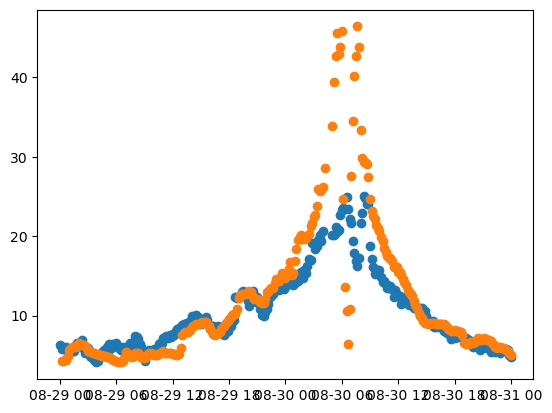

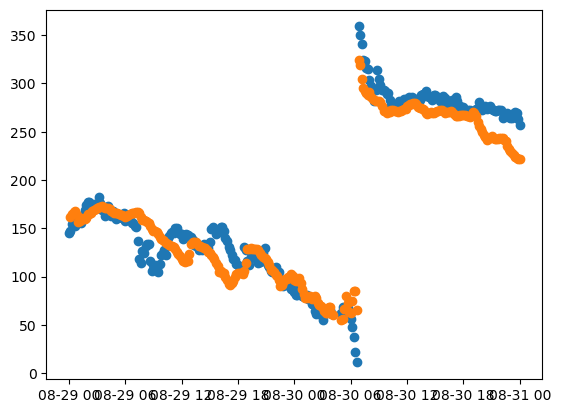

In [189]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(
    ndbc_df.index,
    ndbc_df['WSPD']
)
ax.scatter(
    ndbc_df.index,
    ndbc_df['coamps_10m_wind_speed']
)

fig, ax = plt.subplots()
ax.scatter(
    ndbc_df.index,
    ndbc_df['WDIR']
)
ax.scatter(
    ndbc_df.index,
    ndbc_df['coamps_10m_wind_direction']
)


## Store

Store the updated variables for use in subsequent notebooks.

In [60]:
%%capture
%store microswift_df
%store spotter_df
%store ian_spotter_coamps_df
%store fiona_spotter_coamps_df
%store coamps_ds
%store coamps_xy_ds
%store ibtracs_df
%store sfmr_ds

## References

Holthuijsen, L. H., Powell, M. D., & Pietrzak, J. D. (2012). Wind and waves in extreme hurricanes. J. Geophys. Res., 117(C9), C09003. https://doi.org/10.1029/2012JC007983

Kudryavtsev, V., Yurovskaya, M., & Chapron, B. (2021). Self‐Similarity of Surface Wave Developments Under Tropical Cyclones. Journal of Geophysical Research: Oceans, 126(4), e2020JC016916. https://doi.org/10.1029/2020JC016916


Melville, W. K. (2004). Wave slope and wave age effects in measurements of electromagnetic bias. Journal of Geophysical Research, 109(C7), C07018. https://doi.org/10.1029/2002JC001708
